Task 3: Customer Segmentation / Clustering

1. Data Preprocessing

In [29]:
#Import Libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


Load the Datasets

In [30]:
# Load customer and transaction datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")


Merge Data

In [31]:
# Aggregating transaction data for each customer
data = transactions.groupby("CustomerID").agg({
    "TotalValue": "sum",  # Total spend by the customer
    "TransactionID": "count"  # Number of transactions by the customer
}).rename(columns={"TotalValue": "Total_Spend", "TransactionID": "Transaction_Count"}).reset_index()

# Merge with customer profile data
data = data.merge(customers, on="CustomerID")


Feature Engineering

In [32]:
# Convert SignupDate to datetime and calculate days since sign up
data["SignupDate"] = pd.to_datetime(data["SignupDate"])
data["Days_Since_Signup"] = (pd.Timestamp.now() - data["SignupDate"]).dt.days
data.drop(columns=["SignupDate"], inplace=True)


One-Hot Encoding of Categorical Features

In [33]:
# One-hot encode categorical features (Region)
data = pd.get_dummies(data, columns=["Region"], drop_first=True)


One-Hot Encoding of Categorical Features

In [36]:
# Normalize numerical features
scaler = StandardScaler()
numerical_cols = ["Total_Spend", "Transaction_Count", "Days_Since_Signup"]
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])


2. Clustering

In [37]:
results = {}
for k in range(2, 11):  # Test cluster values from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(data[numerical_cols])  # Apply clustering
    db_index = davies_bouldin_score(data[numerical_cols], clusters)  # DB Index
    silhouette_avg = silhouette_score(data[numerical_cols], clusters)  # Silhouette Score
    results[k] = {"model": kmeans, "db_index": db_index, "silhouette": silhouette_avg}


Evaluate and Find the Optimal Number of Clusters

In [38]:
# Find the optimal number of clusters based on DB Index
best_k = min(results, key=lambda k: results[k]["db_index"])
best_model = results[best_k]["model"]

# Add the cluster labels to the data
data["Cluster"] = best_model.labels_


Display Clustering Results

In [41]:
# Report the optimal number of clusters
print(f"Optimal number of clusters: {best_k}")
print(f"Davies-Bouldin Index: {results[best_k]['db_index']:.3f}")
print(f"Silhouette Score: {results[best_k]['silhouette']:.3f}")


Optimal number of clusters: 4
Davies-Bouldin Index: 0.882
Silhouette Score: 0.350


3. Visualization

In [42]:
# Apply PCA to reduce the dimensionality to 2
pca = PCA(n_components=2)
pca_features = pca.fit_transform(data[numerical_cols])

# Add PCA components to the data for plotting
data["PCA1"] = pca_features[:, 0]
data["PCA2"] = pca_features[:, 1]


Plot the Clusters

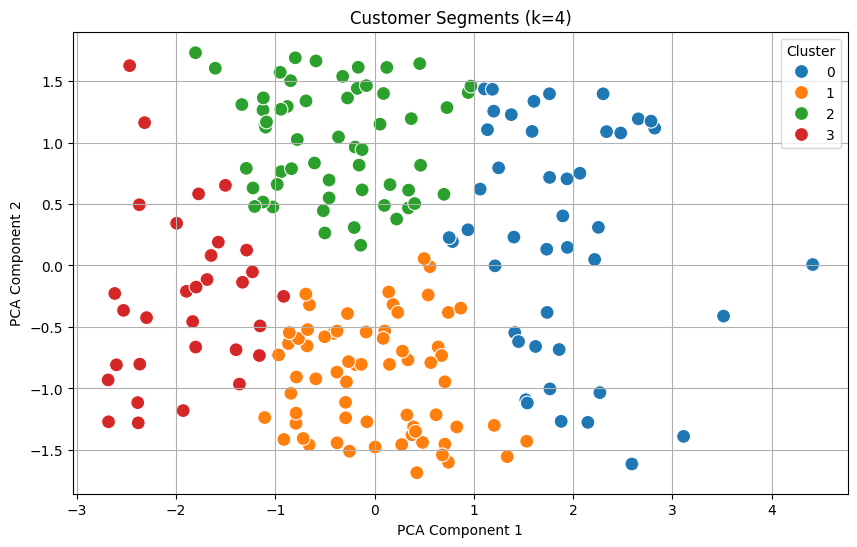

In [43]:
# Plot the clusters in 2D using PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="PCA1", y="PCA2", hue="Cluster", palette="tab10", s=100)
plt.title(f"Customer Segments (k={best_k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


4. Final Report

In [44]:
# Save the clustering results to a CSV file
data[["CustomerID", "Cluster"]].to_csv("Customer_Clusters.csv", index=False)


In [45]:
# Compute average values for each cluster
cluster_profiles = data.groupby("Cluster")[["Total_Spend", "Transaction_Count", "Days_Since_Signup"]].mean()
print(cluster_profiles)


         Total_Spend  Transaction_Count  Days_Since_Signup
Cluster                                                   
0           1.333865           1.273734           0.395465
1           0.044617           0.092186          -0.922443
2          -0.362356          -0.357416           0.981876
3          -1.310263          -1.335434          -0.434453


Conclusion:
This workflow achieves customer segmentation by combining transaction and 
profile information, performing clustering, evaluating the models,
visualizing the clusters, and providing a final report with relevant metrics 
and insights.